In [49]:
import matplotlib.pyplot as plt
import numpy as np
import os
from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from os.path import join

In [50]:
alpha = 0.5
markersize = 12
# number of point figures to plot
num_figs = 2

In [51]:
# pred_dirs specifies location of "+".join(pred_dirs).pkl in processed
pred_dirs = ["early_stopping_logits", "pretrained_logits"]
# score_dirs specifies score group to consider (can be different from pred_dirs) 
score_dirs = ["early_stopping", "CLIP", "CLIP_high", "pretrained"]
# name of dataset to consider
name = "CIFAR10_test"
# name of training dataset
train_set = "CIFAR10_train"
# points - fixed random index subset
# small - smallest non-monotonicity scores
# weird - largest non-monotonicity scores
ind_types = ["points", "small", "weird"]
ind_type = ind_types[2]

In [52]:
pred_dirs.sort()
score_dirs.sort()
group_dir = "+".join(pred_dirs)
score_dir = join("scores", "+".join(score_dirs))
save_dir = join("figures", group_dir)

data_dir = "data"
proc_dir = "processed"

In [53]:
print("loading data")
grouped = load_pickle(join(proc_dir, group_dir + ".pkl"))
scores = load_pickle(join(proc_dir, score_dir + "_scores.pkl"))
print("done")

print("loading dataset")
dataset = get_dataset(data_dir, name)
print("done")

classes = cifar10_label_names

# dataset sizes
default_sizes = {"CIFAR10_train": 50000, "CIFAR10_test": 10000}

# plot group plotting symbols
fmts = {
    "Resnet18": "bo",
    "Densenet121": "ro",
    "Resnet18-pretrained": "c^",
    "Densenet121-pretrained": "m^",
    "ClipViTB32": "go",
}



loading data
done
loading dataset
Files already downloaded and verified
done


In [54]:
# fixed indices chosen by ind_style = "points"
ind_fixed = [1022, 1252, 1977, 2573, 2977, 4974, 5564, 6935, 7170, 7251, 7901, 8002, 8042, 9598, 9773]

if ind_type == "weird":
    indexes = scores[name]["idx"][:num_figs].astype(int)
elif ind_type == "small":
    indexes = scores[name]["idx"][-num_figs:].astype(int)
elif ind_type == "points":
    indexes = ind_fixed[:num_figs]
else:
    raise ValueError("unavailable index type %s" % ind_type)

In [55]:
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
if not os.path.isdir(join(save_dir, name)):
    os.mkdir(join(save_dir, name))

index 5426


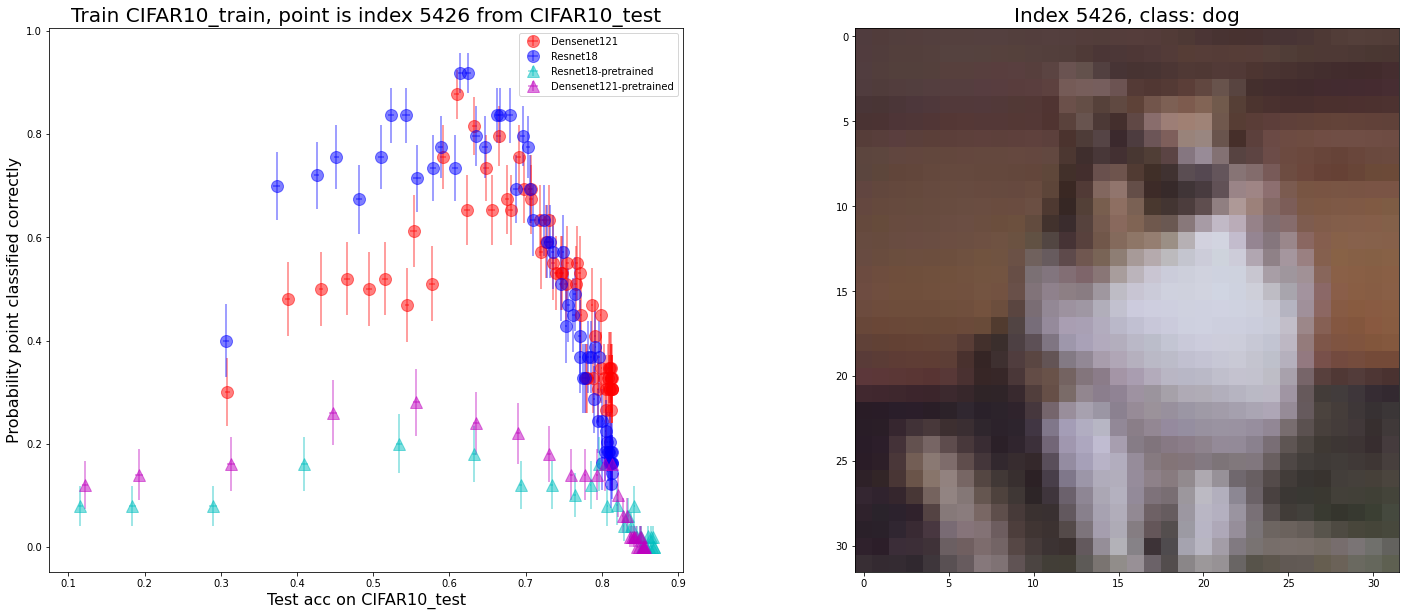

index 7217


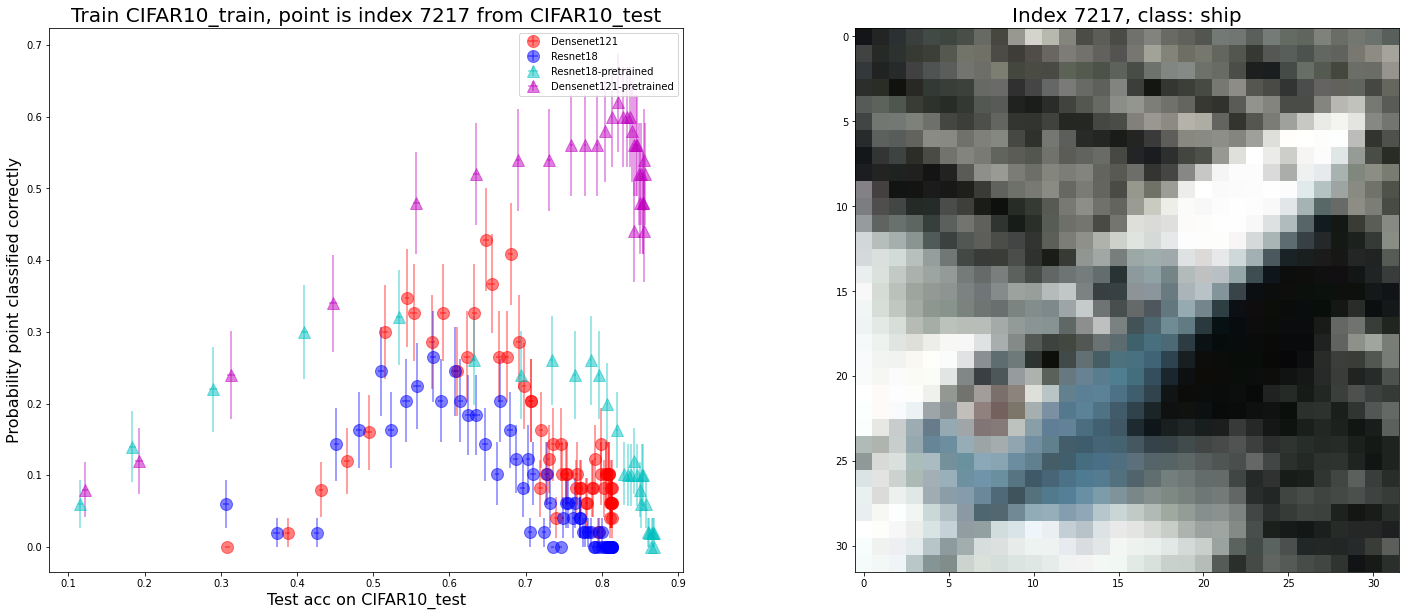

In [56]:
# point plots
for idx in indexes:
    print("index %d" % idx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    for plot_group in grouped[name]:
        dct = grouped[name][plot_group]
        ax1.errorbar(
            dct["x"],
            dct["points"][idx],
            yerr=dct["points_err"][idx],
            xerr=dct["x_err"],
            fmt=fmts[plot_group],
            alpha=alpha,
            markersize=markersize,
            label=plot_group,
        )

    ax1.set_xlabel("Test acc on %s" % name, fontsize=16)
    ax1.set_ylabel("Probability point classified correctly", fontsize=16)
    ax1.set_title(
        "Train %s, point is index %d from %s" % (train_set, idx, name),
        fontsize=20,
    )

    ax1.legend(loc="best")
    img, label = dataset.__getitem__(idx)
    img = np.array(img)
    ax2.imshow(img, interpolation="nearest")
    ax2.set_title("Index %d, class: %s" % (idx, classes[label]), fontsize=20)
    plot_path = join(save_dir, name, ind_type)
    if not os.path.isdir(plot_path):
        os.mkdir(plot_path)
    plt.savefig(join(plot_path, "plot_acc_" + str(idx) + ".png"))
    plt.show()


label 0


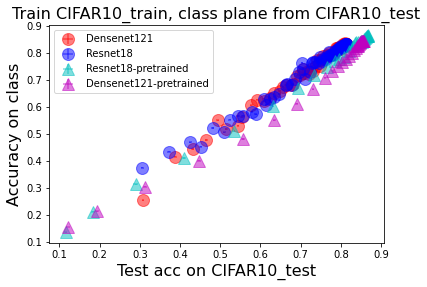

label 1


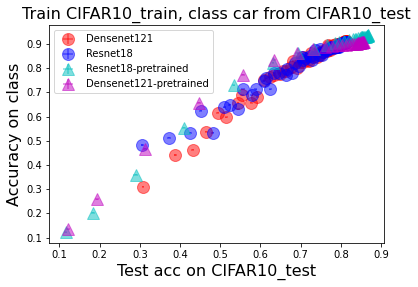

In [57]:
# class plots
# plotting only first few classes for simplicity
num_classes = len(classes)
num_classes = num_figs
for label in range(num_classes):
    print("label %d" % label)
    plt.figure()
    for plot_group in grouped[name]:
        dct = grouped[name][plot_group]
        plt.errorbar(
            dct["x"],
            dct["labels"][label],
            yerr=dct["labels_err"][label],
            xerr=dct["x_err"],
            fmt=fmts[plot_group],
            alpha=alpha,
            markersize=markersize,
            label=plot_group,
        )

    plt.xlabel("Test acc on %s" % name, fontsize=16)
    plt.ylabel("Accuracy on class", fontsize=16)
    plt.title(
        "Train %s, class %s from %s" % (train_set, classes[label], name),
        fontsize=16,
    )

    plt.legend(loc="best")
    class_path = join(save_dir, name, "classes")
    if not os.path.isdir(class_path):
        os.mkdir(class_path)
    plt.savefig(join(class_path, "plot_acc_class" + str(label) + ".png"))
    plt.show()


index 5426
probs


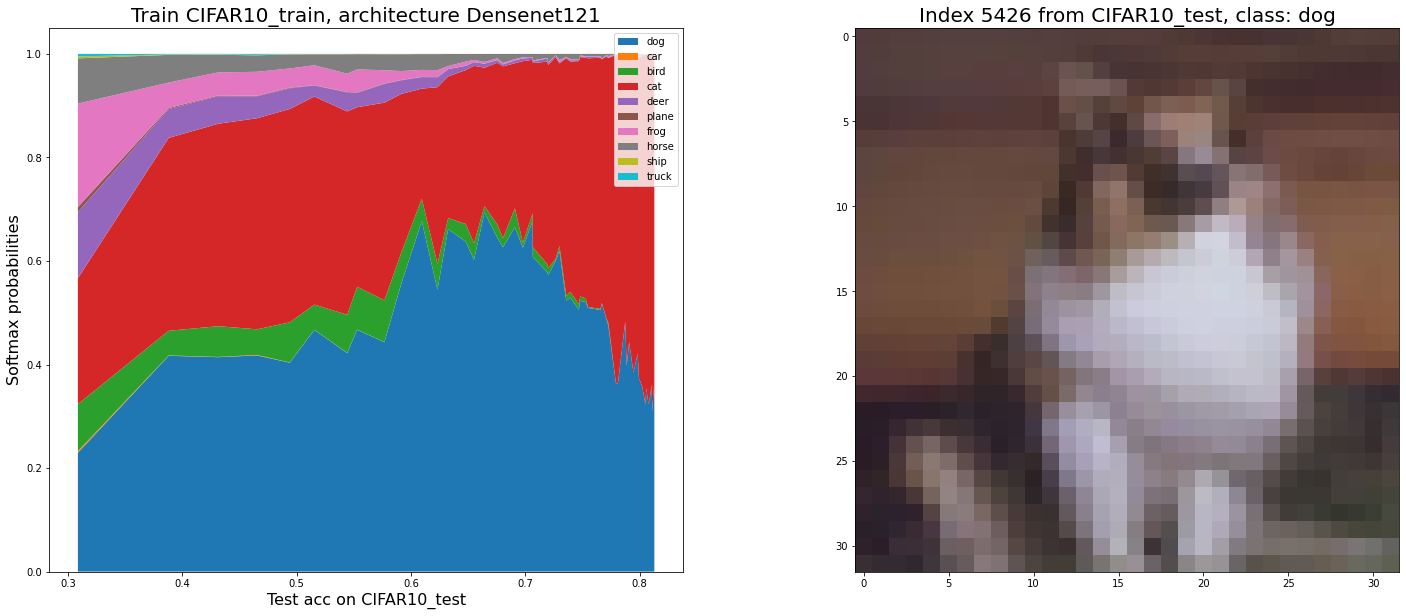

freqs


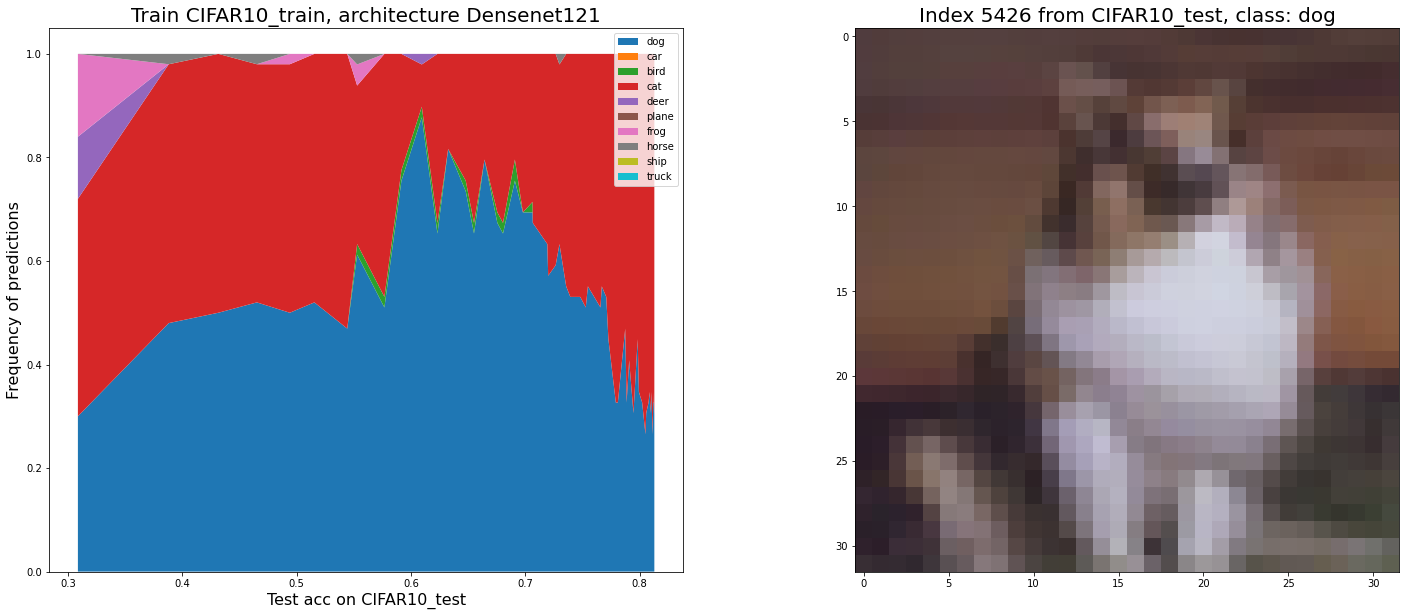

index 7217
probs


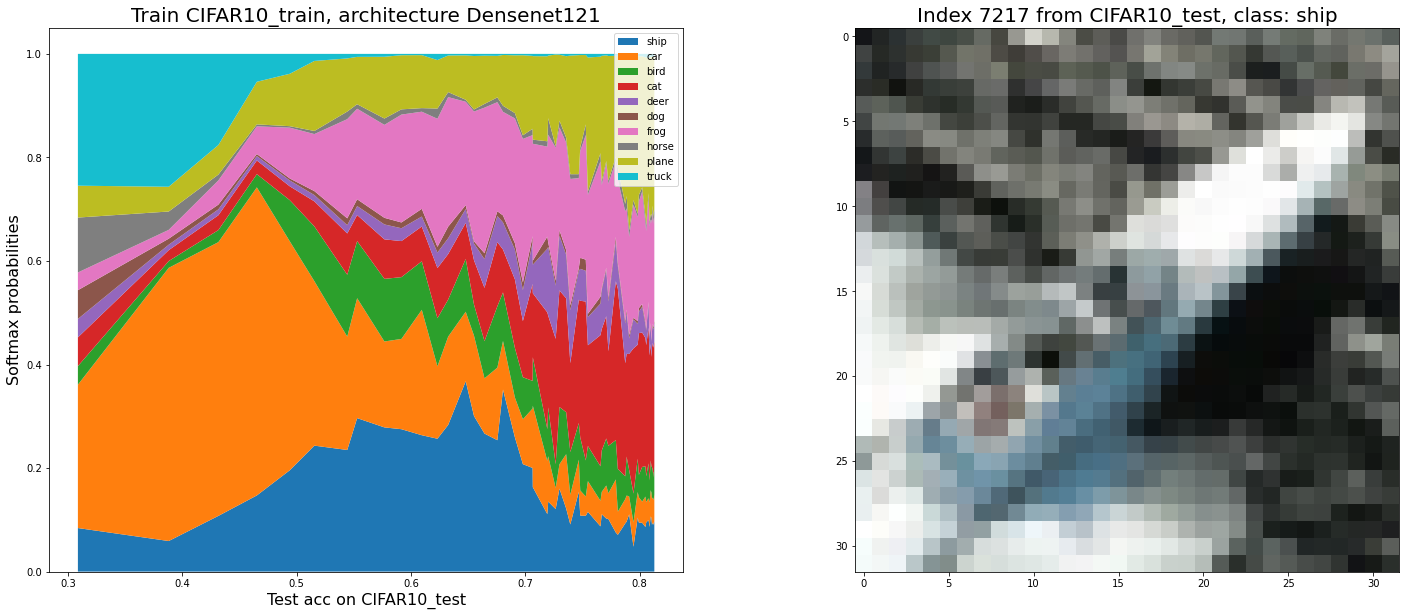

freqs


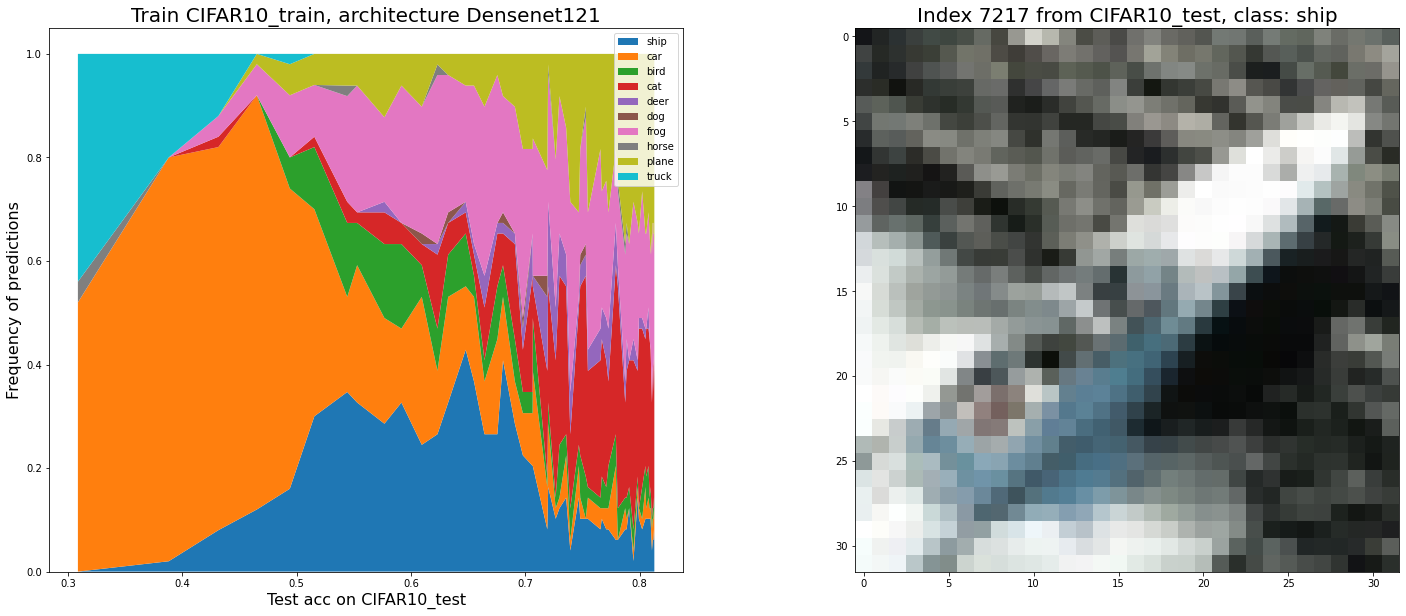

In [59]:
plot_group = "Densenet121"
dct = grouped[name][plot_group]
plot_path = join(save_dir, name, plot_group, ind_type)

# stack plots (needs data with stored logits)
for idx in indexes:
    print("index %d" % idx)
    img, label = dataset.__getitem__(idx)
    img = np.array(img)

    # probs
    print("probs")
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    y = dct["probs"][idx]
    y[[0, label]] = y[[label, 0]]
    labels = classes.copy()
    labels[0], labels[label] = labels[label], labels[0]
    ax1.stackplot(dct["x"], y, labels=labels)
    ax1.set_xlabel("Test acc on %s" % name, fontsize=16)
    ax1.set_ylabel("Softmax probabilities", fontsize=16)
    ax1.set_title(
        "Train %s, architecture %s" % (train_set, plot_group),
        fontsize=20,
    )

    ax1.legend(loc="best")
    ax2.imshow(img, interpolation="nearest")
    ax2.set_title("Index %d from %s, class: %s" % (idx, name, classes[label]), fontsize=20)

    if not os.path.isdir(plot_path):
        os.mkdir(plot_path)
    if not os.path.isdir(join(plot_path, "probs")):
        os.mkdir(join(plot_path, "probs"))
    plt.savefig(join(plot_path, "probs", "plot_probs_" + str(idx) + ".png"))
    plt.show()

    # freqs
    print("freqs")
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    y = dct["freqs"][idx]
    y[[0, label]] = y[[label, 0]]
    labels = classes.copy()
    labels[0], labels[label] = labels[label], labels[0]
    ax1.stackplot(dct["x"], y, labels=labels)
    ax1.set_xlabel("Test acc on %s" % name, fontsize=16)
    ax1.set_ylabel("Frequency of predictions", fontsize=16)
    ax1.set_title(
        "Train %s, architecture %s" % (train_set, plot_group),
        fontsize=20,
    )

    ax1.legend(loc="best")
    img, label = dataset.__getitem__(idx)
    img = np.array(img)
    ax2.imshow(img, interpolation="nearest")
    ax2.set_title("Index %d from %s, class: %s" % (idx, name, classes[label]), fontsize=20)
    if not os.path.isdir(plot_path):
        os.mkdir(plot_path)
    if not os.path.isdir(join(plot_path, "freqs")):
        os.mkdir(join(plot_path, "freqs"))
    plt.savefig(join(plot_path, "freqs", "plot_freqs_" + str(idx) + ".png"))
    plt.show()